In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import collections
import numpy as np
import pandas as pd
import shutil
import os
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv1D
from sklearn import preprocessing
from scipy.stats import zscore
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 26
IMG_SIZE = 200


def preprocess_img_hsv(img):
    # Histogram normalization in v channel
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)

    # central square crop
    min_side = min(img.shape[:-1])
    centre = img.shape[0] // 2, img.shape[1] // 2
    img = img[centre[0] - min_side // 2:centre[0] + min_side // 2,
              centre[1] - min_side // 2:centre[1] + min_side // 2,
              :]

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img, -1)

    return img


import sys
import cv2

def preprocessing_img_black_and_white(img):
    im_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    skin_ycrcb_mint = np.array((0, 133, 77))
    skin_ycrcb_maxt = np.array((255, 173, 127))
    skin_ycrcb = cv2.inRange(im_ycrcb, skin_ycrcb_mint, skin_ycrcb_maxt)
    return skin_ycrcb

In [3]:
import os

testFiles=[]
trainFiles=[]
for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'):
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if(int(number)>100):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if file.endswith('_test.jpg'):
                    if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                        testFiles.append(file_path)
                else:
                    if ((not "nothing" in file) and (not "space" in file) and (not "del" in file)):
                        trainFiles.append(file_path)
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

0
2600


In [4]:
#creating the sample set of 20 test images for each alphabet
import os

testFiles=[]

for root, dirs, files in os.walk('./data/asl-alphabet/asl_alphabet_train/'): #asl_alphabet_test_sample
     for file in files:
            if file.endswith('.jpg'):
                if not file.endswith('_test.jpg'):
                    number=file[1:file.find('.')]
                    if not number.isdigit():
                        continue
                    if((int(number)<=100) or int(number)>120):
                        continue
                file_path = os.path.join(root,file)
                #print(file_path)
                if (not file.startswith('nothing_') and not file.startswith('space_') and not(file.startswith('del_'))):
                    testFiles.append(file_path)
                    
testFiles.sort()
trainFiles.sort()
print(len(testFiles))
print(len(trainFiles))

520
2600


In [5]:
from skimage import io
import numpy as np
j=0
# numpy_array_train = np.empty([78000,200,200,3])
x_train = np.empty([2600,200,200])
y_train = []
y_train_for_df = []
alphabet_array = []
alphabet_array.append('A')
alphabet_array.append('B')
alphabet_array.append('C')
alphabet_array.append('D')
alphabet_array.append('E')
alphabet_array.append('F')
alphabet_array.append('G')
alphabet_array.append('H')
alphabet_array.append('I')
alphabet_array.append('J')
alphabet_array.append('K')
alphabet_array.append('L')
alphabet_array.append('M')
alphabet_array.append('N')
alphabet_array.append('O')
alphabet_array.append('P')
alphabet_array.append('Q')
alphabet_array.append('R')
alphabet_array.append('S')
alphabet_array.append('T')
alphabet_array.append('U')
alphabet_array.append('V')
alphabet_array.append('W')
alphabet_array.append('X')
alphabet_array.append('Y')
alphabet_array.append('Z')
k=0
print(len(trainFiles))
for i in trainFiles:    
    x_train[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_train.append(alphabet_array[k])
    if (j%100) == 0: #j%3000 for complete
        k=k+1

print(len(x_train))
print(x_train[1299])

2600
2600
[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 255. ...   0.   0.   0.]
 ...
 [  0.   0. 255. ...   0. 255.   0.]
 [  0.   0.   0. ... 255.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [6]:
from skimage import io
import numpy as np
j=0
k=0
y_test = []
x_test = np.empty([520,200,200]) 

for i in testFiles:    
    x_test[j]=preprocessing_img_black_and_white(io.imread(i))
    j=j+1
    y_test.append(alphabet_array[k])
    if (j%20) == 0:
        k=k+1


x_test.shape

(520, 200, 200)

In [7]:
y_train_np=np.asarray(y_train)
y_test_np = np.asarray(y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train_np.shape)
print(y_test_np.shape)

(2600, 200, 200)
(520, 200, 200)
(2600,)
(520,)


In [8]:
print(x_train.dtype)
print(x_test.dtype)


float64
float64


In [9]:
print(x_train.dtype)
print(x_test.dtype)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


float64
float64


In [10]:
# #previous was not their
# # normalize the data values to the range [0, 1]
# x_train /= 255
# x_test /= 255
# print(x_test[10])

In [11]:
le = preprocessing.LabelEncoder()
print(x_train.shape)
print(x_test.shape)
y_train = le.fit_transform(y_train_np)
y_test = le.fit_transform(y_test_np)
print(y_train.shape)
print(y_test.shape)


(2600, 200, 200)
(520, 200, 200)
(2600,)
(520,)


In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2600, 200, 200)
(520, 200, 200)
(2600,)
(520,)


In [13]:
x_train=x_train.reshape(len(x_train),-1)
x_test=x_test.reshape(len(x_test),-1)

In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2600, 40000)
(520, 40000)
(2600,)
(520,)


In [15]:
x_train[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

<h3>AdaBoost Classifier Using Decision Tree Classifier</h3>

Plotting confusion matrix


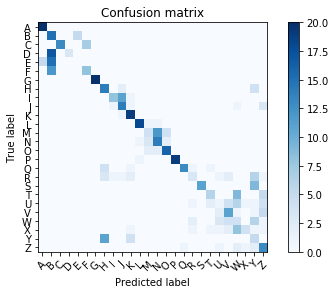

             precision    recall  f1-score   support

          0       0.80      1.00      0.89        20
          1       0.25      0.75      0.38        20
          2       1.00      0.65      0.79        20
          3       1.00      0.15      0.26        20
          4       0.00      0.00      0.00        20
          5       0.53      0.40      0.46        20
          6       1.00      1.00      1.00        20
          7       0.44      0.70      0.54        20
          8       0.80      0.40      0.53        20
          9       0.48      0.70      0.57        20
         10       0.66      0.95      0.78        20
         11       0.90      0.90      0.90        20
         12       0.40      0.20      0.27        20
         13       0.48      0.70      0.57        20
         14       0.73      0.80      0.76        20
         15       1.00      0.95      0.97        20
         16       0.93      0.65      0.76        20
         17       0.38      0.15      0.21   

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=26), n_estimators=50)
# 105 - 7.5
# 40 - 11.53
# 26 - 11.53

#max depth=26 - 57.88 n_estimator=50
# 50 - 54.80
# 40-55.38
# 30- 53.07
# 35 - 53.26
clf.fit(x_train, y_train)
rfc_pred = clf.predict(x_test)
#print(rfc_pred)
#Compute confusion matrix
cm = confusion_matrix(y_test, rfc_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_test, rfc_pred))
print("Accuracy :", metrics.accuracy_score(y_test, rfc_pred))

<h3>AdsBoost using Extra Tree Classifier</h3>

Plotting confusion matrix


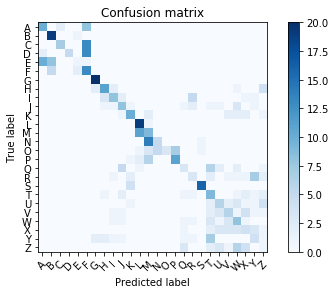

             precision    recall  f1-score   support

          0       0.45      0.50      0.48        20
          1       0.59      0.95      0.73        20
          2       0.78      0.35      0.48        20
          3       1.00      0.25      0.40        20
          4       0.25      0.05      0.08        20
          5       0.27      0.65      0.38        20
          6       0.83      1.00      0.91        20
          7       0.61      0.55      0.58        20
          8       0.53      0.40      0.46        20
          9       0.38      0.40      0.39        20
         10       0.53      0.50      0.51        20
         11       0.56      0.95      0.70        20
         12       0.26      0.45      0.33        20
         13       0.50      0.25      0.33        20
         14       1.00      0.15      0.26        20
         15       0.61      0.55      0.58        20
         16       0.27      0.15      0.19        20
         17       0.23      0.15      0.18   

In [17]:
from sklearn.tree import ExtraTreeClassifier
extraTree = ExtraTreeClassifier(random_state=0,criterion='entropy',max_leaf_nodes=520)
# 500: 44.42
#520: 49.60

clf = AdaBoostClassifier(base_estimator=extraTree, n_estimators=50)
# 50: 49.60
# 52: 47.11
# 47: 47.5
# 48: 49.423


clf.fit(x_train, y_train)
rfc_pred = clf.predict(x_test)
#print(rfc_pred)
#Compute confusion matrix
cm = confusion_matrix(y_test, rfc_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_test, rfc_pred))
print("Accuracy :", metrics.accuracy_score(y_test, rfc_pred))

<h3>Bagging Classifier</h3>

Plotting confusion matrix


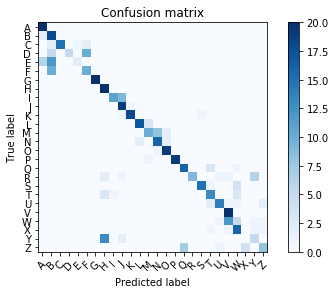

             precision    recall  f1-score   support

          0       0.71      1.00      0.83        20
          1       0.38      0.90      0.54        20
          2       1.00      0.75      0.86        20
          3       1.00      0.25      0.40        20
          4       0.67      0.10      0.17        20
          5       0.45      0.50      0.48        20
          6       1.00      1.00      1.00        20
          7       0.53      1.00      0.69        20
          8       0.92      0.55      0.69        20
          9       0.59      0.95      0.73        20
         10       0.95      0.90      0.92        20
         11       0.89      0.85      0.87        20
         12       0.71      0.50      0.59        20
         13       0.64      0.80      0.71        20
         14       0.83      0.95      0.88        20
         15       1.00      0.95      0.97        20
         16       0.70      0.80      0.74        20
         17       1.00      0.45      0.62   

In [18]:
from sklearn.ensemble import BaggingClassifier

clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=520), n_estimators=100)

#max depth=26 - n_estimator=50 : 65.76
#max depth=520 - n_estimator=50 : 65.57
#max depth=520 - n_estimator=100 : 66.73

clf.fit(x_train, y_train)
rfc_pred = clf.predict(x_test)
#print(rfc_pred)
#Compute confusion matrix
cm = confusion_matrix(y_test, rfc_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_test, rfc_pred))
print("Accuracy :", metrics.accuracy_score(y_test, rfc_pred))

<h3>Quadratic Discriminant Analysis: QDA</h3>

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Plotting confusion matrix


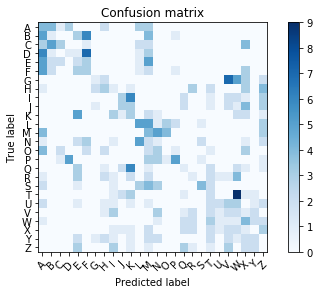

             precision    recall  f1-score   support

          0       0.09      0.20      0.13        20
          1       0.07      0.05      0.06        20
          2       0.33      0.15      0.21        20
          3       0.11      0.05      0.07        20
          4       0.07      0.10      0.08        20
          5       0.12      0.15      0.13        20
          6       0.20      0.05      0.08        20
          7       0.19      0.15      0.17        20
          8       0.00      0.00      0.00        20
          9       0.25      0.15      0.19        20
         10       0.11      0.15      0.12        20
         11       0.24      0.25      0.24        20
         12       0.08      0.20      0.11        20
         13       0.04      0.05      0.05        20
         14       0.00      0.00      0.00        20
         15       0.50      0.25      0.33        20
         16       0.07      0.05      0.06        20
         17       0.09      0.05      0.06   

In [19]:
import sklearn.discriminant_analysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
clf.fit(x_train, y_train)
qda_pred = clf.predict(x_test)
# print(qda_pred)
#Compute confusion matrix
cm = confusion_matrix(y_test, qda_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_test, qda_pred))

print("Accuracy :", metrics.accuracy_score(y_test, qda_pred))

<h3>Random Forest</h3>

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  1
  3  0  0  0  3  3  3  3  0  0  2  0  1  1  1  1  1  1  1  1  1  1  1  1
  1  0  4  4  5  5  5  5  5  5  5  5  5  5  5  5  1  1  1  1  1  1  1  1
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  9  9  8  9  9  8  9  9
  8  9  8  9  9  8  8  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 14 14 14 14 14 14 14 14
 14 14 13 13 13 13 13 13 13 13 13 13 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16 16

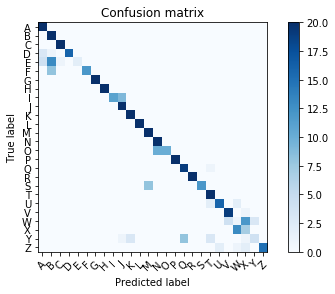

             precision    recall  f1-score   support

          0       0.74      1.00      0.85        20
          1       0.48      1.00      0.65        20
          2       0.95      1.00      0.98        20
          3       1.00      0.80      0.89        20
          4       1.00      0.10      0.18        20
          5       1.00      0.60      0.75        20
          6       1.00      1.00      1.00        20
          7       1.00      1.00      1.00        20
          8       1.00      0.55      0.71        20
          9       0.67      1.00      0.80        20
         10       0.87      1.00      0.93        20
         11       1.00      1.00      1.00        20
         12       0.71      1.00      0.83        20
         13       0.67      1.00      0.80        20
         14       1.00      0.50      0.67        20
         15       1.00      1.00      1.00        20
         16       0.70      0.95      0.81        20
         17       1.00      1.00      1.00   

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=210, max_depth=18, random_state=0, max_features='log2')#18
clf.fit(x_train, y_train)
rfc_pred = clf.predict(x_test)
print(rfc_pred)
#Compute confusion matrix
cm = confusion_matrix(y_test, rfc_pred)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, alphabet_array)
plt.show()

print(classification_report(y_test, rfc_pred))
print("Precision :", metrics.accuracy_score(y_test, rfc_pred))


<h3>Voting Classifier</h3>

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier

clf1 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=26), n_estimators=50)
clf2 = AdaBoostClassifier(base_estimator=extraTree, n_estimators=48)
clf3 = QDA()
clf4 = RandomForestClassifier(n_estimators=210, max_depth=18, random_state=0, max_features='log2')
eclf = VotingClassifier(estimators=[('ada', clf1), ('adaextra', clf2), ('qda', clf3),('randomForest',clf4)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['AdaBoost Classifier using Decision Tree', 'AdaBoost Classifier using Extra Tree','Quadratic Discriminant Analysis','Random Forest Classifier']):
    scores = cross_val_score(clf, x_train, y_train, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.63 (+/- 0.01) [AdaBoost Classifier using Decision Tree]
Accuracy: 0.52 (+/- 0.03) [AdaBoost Classifier using Extra Tree]


/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.14 (+/- 0.02) [Quadratic Discriminant Analysis]
Accuracy: 0.81 (+/- 0.02) [Random Forest Classifier]
